In [1]:
# 01/20/26: ON: Euclid DM Decay Constraint Estimates

import numpy as np
import sys, os

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib import colors as mplcolors


import csv
from scipy import interpolate

import scipy
from scipy import integrate

from scipy.integrate import quad
from scipy.interpolate import interp1d

from scipy.integrate import solve_ivp

import glob
import time
from glob import glob

import re

# Details for minimizer
from scipy.optimize import dual_annealing
from scipy.stats import poisson, norm
from scipy.special import loggamma

from scipy.special import xlogy

from scipy.optimize import minimize
from scipy.optimize import differential_evolution

from scipy import stats

import healpy as hp
from healpy.newvisufunc import projview
from astropy.table import Table

from scipy.signal import savgol_filter


##############
#For plotting
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from matplotlib import rc
from matplotlib import rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True
#rcParams['text.latex.unicode'] = True
#rcParams['text.fontsize'] = 16

In [2]:
###########################
# Setup Plotting Defaults #
###########################
# For more options see https://matplotlib.org/users/customizing.html

# Commands for high detail plots (much larger in file size though)
#mpl.rcParams['agg.path.chunksize'] = 1000
#mpl.rcParams['savefig.dpi'] = 1000

# Line styles
import matplotlib as mpl
#mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid'])


# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.labelpad'] = 10.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.8
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 7,7

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24


fontsize=30
#mpl.rcParams['agg.path.chunksize'] = 1000
#mpl.rcParams['savefig.dpi'] = 1000

In [3]:
def theta2tau(s2theta, ms):
    """ Convert from ms [keV] and sin2theta to lifetime [s]
    """
    
    return 1./(1.361e-29*(s2theta/1.e-7)*ms**5.)

hbar = 6.582119569e-16 # [eV.s]

def theta2gagg(s2theta, ms):
    """ Convert from ms [keV] and sin2theta to gagg [1/GeV]
    """
    
    Gamma = hbar/theta2tau(s2theta, ms)/2. # [eV]
    
    return np.sqrt(64.*np.pi*Gamma/(ms*1.e3)**3.)*1.e9 # [1/GeV]

def tau2theta(tau, ms):
    """ Convert from lifetime [s] and ms [keV] to sin^2(2theta) """
    return 1.e-7 / (1.361e-29 * ms**5. * tau)

def gagg2theta(gagg, ms):
    """ Convert from gagg [1/GeV] and ms [keV] to sin^2(2theta) """
    
    Gamma = (gagg/1.e9)**2 * (ms*1.e3)**3. / (64.*np.pi)  # [eV]
    tau = hbar / (2.*Gamma)                              # [s]
    
    return tau2theta(tau, ms)

def gagg2tau(gagg, ms):
    """ Convert from gagg [1/GeV] and ms [keV] to sin^2(2theta) """
    
    Gamma = (gagg/1.e9)**2 * (ms*1.e3)**3. / (64.*np.pi)  # [eV]
    tau = hbar / (2.*Gamma)                              # [s]
    
    return tau

# Euclid Estimates

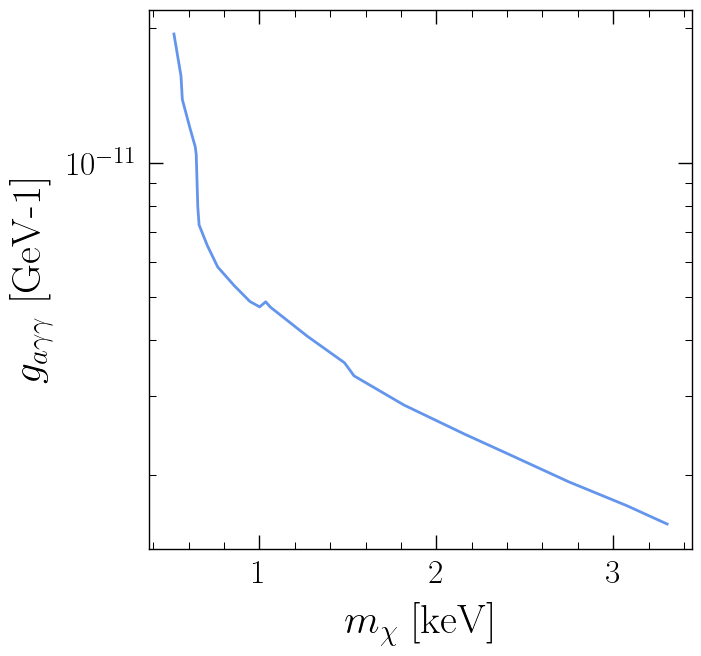

In [12]:
#first examine the Spherex ones

#load in those limits

spherex_dat = np.loadtxt("../projected_limits/"+"SPHEREx_MW_Deepfield_2year_2412.12286_proj.txt", delimiter=',')
m_DM_eV = spherex_dat[:,0]
gagg = spherex_dat[:,1]

plt.plot(m_DM_eV, gagg)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_{\chi}$ [keV]')
plt.ylabel(r'$g_{a\gamma \gamma}$ [GeV-1]')

plt.show()


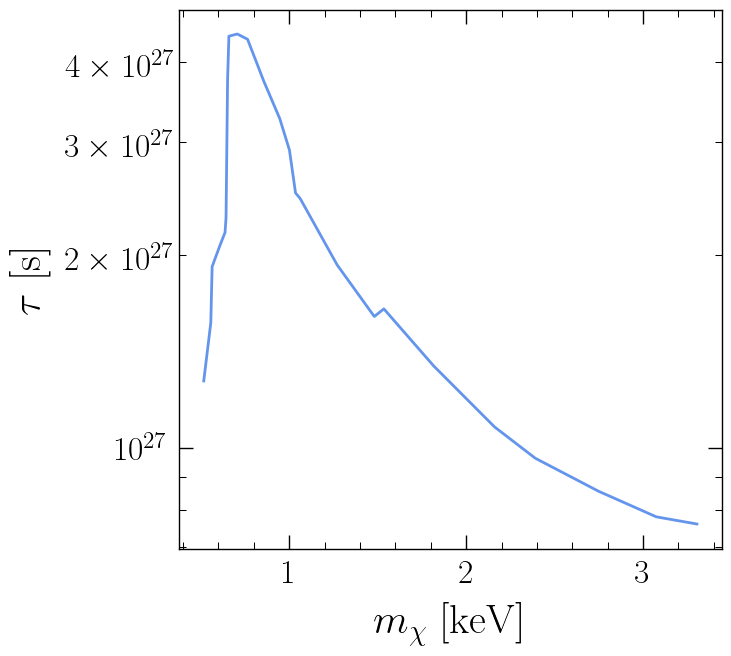

In [14]:
spherex_m = m_DM_eV
spherex_tau = gagg2tau(gagg, m_DM_eV/1000)

plt.plot(spherex_m, spherex_tau)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_{\chi}$ [keV]')
plt.ylabel(r'$\tau$ [s]')

plt.show()


In [ ]:
#now we rescale to Euclid specs


In [133]:
#note, Euclid only ~2000 deg2 of data so far, but only 63 deg2 in its releases

#same D-factor
#let's say same search

#let's do rescaling for VIS

#tau_E/tau_S = D fac x sigma_SB fac x sqrt(fraction fac x Area fac) x sqrt(T fac) x sqrt(effective line width fac)

D_diff = 1.5 #might get closer to GC

sigma_SB_diff = 3.0/1.5 #surface brightness noise, guess (top is spherex, bottom is Euclid)

A_diff = 63/100 #deg2/deg2
f_diff = 0.1/0.9 #say Euclid keeps about 10% of sky, whereas Spherex can get all deep field, or most

line_width_diff = 2/100 #R factor different by 2/100 roughly between VIS and SPHEREx (2 from one broad band from VIS, 700/350nm)

tau_VIS_fac = spherex_tau[-1] * D_diff * sigma_SB_diff * np.sqrt(f_diff*A_diff) * np.sqrt(line_width_diff)

D_diff = 1.5 #might get closer to GC

sigma_SB_diff = 3.0/1.5 #surface brightness noise, guess (top is spherex, bottom is Euclid)

A_diff = 63/100 #deg2/deg2
f_diff = 0.1/0.9 #say Euclid keeps about 10% of sky, whereas Spherex can get all deep field, or most

line_width_diff = 300/100 #R factor different by 300/100 roughly between NISP and SPHEREx

tau_NISP_fac = interpolate.interp1d(spherex_m, spherex_tau)(1.9) * D_diff * sigma_SB_diff * np.sqrt(f_diff*A_diff) * np.sqrt(line_width_diff) * 1.0
#note for NISP there are penalties for slitless sensitivty



In [143]:
#modulate with eff Area of VIS 


HC_eVA = 12398.4193  # eV Angstroms

def load_csv_lambda_A_eff_cm2(path, delimiter=",", skiprows=0):
    """
    Returns (E_eV, eff_cm2) sorted by increasing E_eV.
    Assumes col0 = wavelength [Å], col1 = effective area [cm^2].
    """
    data = np.loadtxt(path, delimiter=delimiter, skiprows=skiprows)
    lam_A = data[:, 0] * 1e4
    eff = data[:, 1]

    # Convert Å -> eV
    E_eV = HC_eVA / lam_A

    # Sort by energy (np.interp wants x increasing)
    order = np.argsort(E_eV)
    return E_eV[order], eff[order]

E1, A1 = load_csv_lambda_A_eff_cm2("../existing_limits/Euclid_VIS_A.csv", delimiter=",", skiprows=0)
M1_VIS = E1 * 2 #x2 for mass
tau_VIS = tau_VIS_fac * A1/np.max(A1)

E1, A1 = load_csv_lambda_A_eff_cm2("../existing_limits/Euclid_NISP_A.csv", delimiter=",", skiprows=0)
M1_NISP = E1 * 2 #x2 for mass
tau_NISP = tau_NISP_fac * A1/np.max(A1)

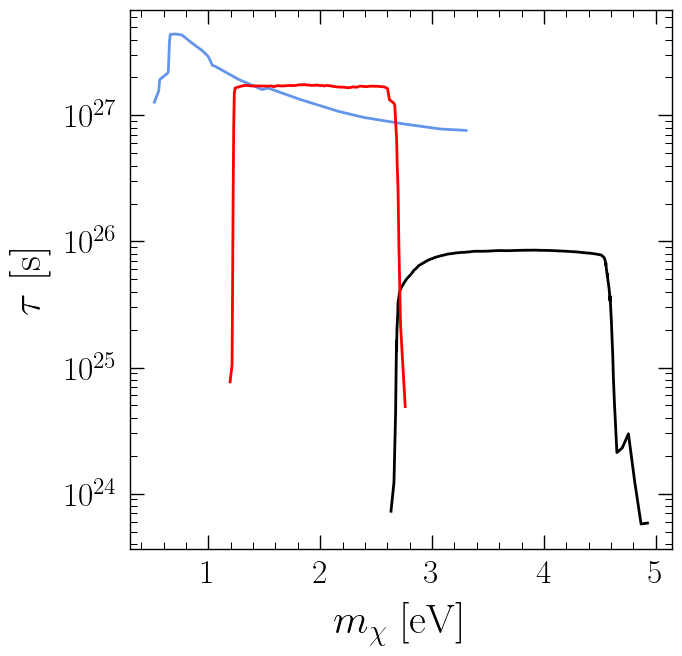

In [144]:
plt.plot(spherex_m, spherex_tau)
plt.plot(M1_VIS, tau_VIS, color='k')
plt.plot(M1_NISP, tau_NISP, color='r')

#plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_{\chi}$ [eV]')
plt.ylabel(r'$\tau$ [s]')

plt.show()

In [145]:
# --- common mass grid over the UNION of ranges ---
mmin = min(M1_VIS.min(), M1_NISP.min())
mmax = max(M1_VIS.max(), M1_NISP.max())
M1_common = np.logspace(np.log10(mmin), np.log10(mmax), 2000)

# --- interpolate onto common grid ---
# outside range -> NaN
tau_VIS_i  = np.interp(M1_common, M1_VIS,  tau_VIS,  left=np.nan, right=np.nan)
tau_NISP_i = np.interp(M1_common, M1_NISP, tau_NISP, left=np.nan, right=np.nan)

# --- combine in quadrature where both exist; otherwise keep the one that exists ---
tau_combo = np.full_like(M1_common, np.nan, dtype=float)

both = np.isfinite(tau_VIS_i) & np.isfinite(tau_NISP_i)
only_vis  = np.isfinite(tau_VIS_i) & ~np.isfinite(tau_NISP_i)
only_nisp = ~np.isfinite(tau_VIS_i) & np.isfinite(tau_NISP_i)

tau_combo[both] = np.sqrt(tau_VIS_i[both]**2 + tau_NISP_i[both]**2)
tau_combo[only_vis] = tau_VIS_i[only_vis]
tau_combo[only_nisp] = tau_NISP_i[only_nisp]


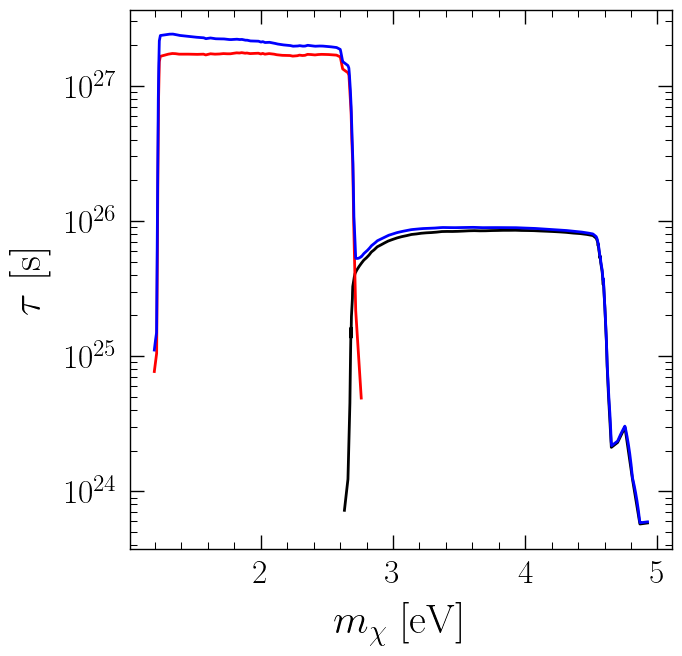

In [151]:
# choose scale (tune this)
m0 = M1_common[0]   # eV

# attenuation factor: 1 at small m, ~0.2 at large m
A = 1.0 + 1.2 * np.exp(-M1_common / m0)

tau_combo_att = tau_combo*A

plt.plot(M1_VIS, tau_VIS, color='k')
plt.plot(M1_NISP, tau_NISP, color='r')
plt.plot(M1_common, tau_combo_att, color='b')

#plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_{\chi}$ [eV]')
plt.ylabel(r'$\tau$ [s]')

plt.show()

In [152]:
# limit_dict = {"mDM_eV": M1_common,
#               "tau_limit_arr_s": tau_combo_att
#              }
# np.save("../projected_limits/"+"Euclid.npy", limit_dict)